[PyTorch](https://pytorch.org) is a great library for machine learning. You can in a few lines of codes retrieve a dataset, define your model, add a cost function and then train your model. It's quite magic to copy and paste code from the internet and get the [LeNet network](https://github.com/pytorch/examples/tree/master/mnist) working in a few seconds to achieve more than 98% accuracy.

However, it can be tedious sometimes to extend existing objects and here, I will manipulate some ways to define the right dataset for your application. In particular I will modify the call to a standard dataset ([MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)) to place the characters at random places in a large image.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
import matplotlib.pyplot as plt

## loading MNIST

We will use the ``Dataset`` object
https://pytorch.org/docs/stable/data.html
and the MNIST example from the [torchvision datasets](https://pytorch.org/docs/stable/torchvision/datasets.html).

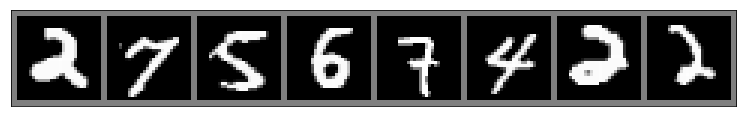

In [2]:
from torchvision.datasets import MNIST
import torch
from torchvision import datasets, transforms

mnist = datasets.MNIST('/tmp/data',
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))
data_loader = torch.utils.data.DataLoader(mnist,
                       batch_size=8,
                       shuffle=True)

def show(data_loader):

    images, foo = next(iter(data_loader))

    from torchvision.utils import make_grid
    npimg = make_grid(images, normalize=True, pad_value=.5).numpy()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=((13, 5)))
    import numpy as np
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.setp(ax, xticks=[], yticks=[])

    return fig, ax
fig, ax = show(data_loader)
plt.show()

It's easy to define some geometrical transforms such as cropping:

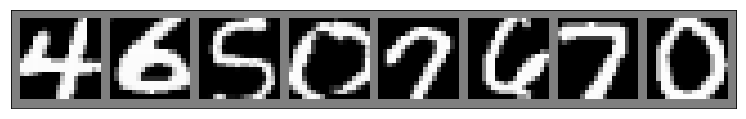

In [3]:

mnist = datasets.MNIST('/tmp/data',
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.CenterCrop(18),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))
data_loader = torch.utils.data.DataLoader(mnist,
                       batch_size=8,
                       shuffle=True)

fig, ax = show(data_loader)
plt.show()

... or a zoom out (by cropping by a size bigger than the input size, which seems unintuitive at first):

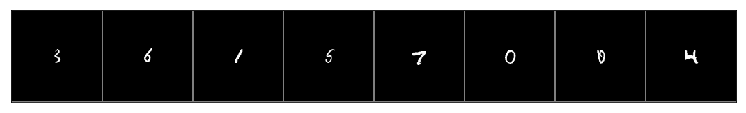

In [4]:
from torchvision.datasets import MNIST
import torch
from torchvision import datasets, transforms

mnist = datasets.MNIST('/tmp/data',
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.CenterCrop(128),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))
data_loader = torch.utils.data.DataLoader(mnist,
                       batch_size=8,
                       shuffle=True)

fig, ax = show(data_loader)
plt.show()

More info can be found at:

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

or at:

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel


In [5]:
torch.Tensor

torch.Tensor

The code for defining this particular dataset is available :

https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py

and can be a great inspiration to see how the object is defined... in this particular case, we wish to translate the MNIST image in the full scale image.

In [6]:
datasets.MNIST?

Init signature:
datasets.MNIST(
    root,
    train=True,
    transform=None,
    target_transform=None,
    download=False,
)
Docstring:     
`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

Args:
    root (string): Root directory of dataset where ``processed/training.pt``
        and  ``processed/test.pt`` exist.
    train (bool, optional): If True, creates dataset from ``training.pt``,
        otherwise from ``test.pt``.
    download (bool, optional): If true, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py
Type:           t

Moreover, thes following code is a great inspiration to generate arbitrary data:

https://github.com/pytorch/vision/blob/master/torchvision/datasets/fakedata.py

In [7]:
class FakeData(torch.utils.data.Dataset):
    """A fake dataset that returns randomly generated images and returns them as PIL images
    Args:
        size (int, optional): Size of the dataset. Default: 1000 images
        image_size(tuple, optional): Size if the returned images. Default: (3, 224, 224)
        num_classes(int, optional): Number of classes in the datset. Default: 10
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        random_offset (int): Offsets the index-based random seed used to
            generate each image. Default: 0
    """

    def __init__(self, size=1000, image_size=(3, 224, 224), num_classes=10,
                 transform=None, target_transform=None, random_offset=0):
        self.size = size
        self.num_classes = num_classes
        self.image_size = image_size
        self.transform = transform
        self.target_transform = target_transform
        self.random_offset = random_offset

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        # create random image that is consistent with the index id
        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)
        img = torch.randn(*self.image_size)
        target = torch.Tensor(1).random_(0, self.num_classes)[0]
        torch.set_rng_state(rng_state)

        # convert to PIL Image
        img = transforms.ToPILImage()(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return self.size

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

mnist = FakeData(transform=transforms.Compose([
                           transforms.CenterCrop(128),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))

In [8]:
mnist

Dataset FakeData
    Number of datapoints: 1000
    Transforms (if any): Compose(
                             CenterCrop(size=(128, 128))
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

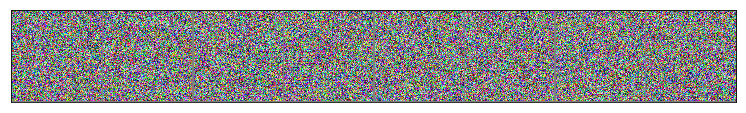

In [9]:
    
data_loader = torch.utils.data.DataLoader(mnist,
                       batch_size=8,
                       shuffle=True)

fig, ax = show(data_loader)
plt.show()      

## a simpler way

One can also create a function and add it to the list of transforms:

In [10]:
class z_score(object):
    '''
    Image per Image z-score normalization

    Image = (Image-mean(Image))/std(Image)
    '''
    def __call__(self, img):
        img = img - img.mean()
        img = img / img.std()

        return img

class rock_and_roll(object):
    '''
    Image per Image z-score normalization

    Image = (Image-mean(Image))/std(Image)
    '''
    def __call__(self, img):
        
        img = img.numpy()
        x_roll , y_roll = int(np.random.rand()*img.shape[1]), int(np.random.rand()*img.shape[2])
        img = np.roll(img, x_roll, axis=1)
        img = np.roll(img, y_roll, axis=2)
        img = torch.Tensor(img)

        return img
    

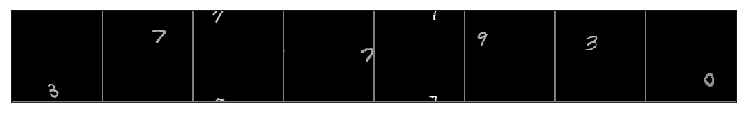

In [11]:
from torchvision.datasets import MNIST
import torch
from torchvision import datasets, transforms

mnist = datasets.MNIST('/tmp/data',
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.CenterCrop(128),
                           transforms.ToTensor(),
                           z_score(),
                           rock_and_roll(),
                           transforms.Normalize((0.1307,), (0.3081,))]))
data_loader = torch.utils.data.DataLoader(mnist,
                       batch_size=8,
                       shuffle=True)

fig, ax = show(data_loader)
plt.show()

## some book keeping for the notebook

In [12]:
%load_ext watermark
%watermark

2019-03-14T14:50:46+01:00

CPython 3.7.2
IPython 7.3.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit


In [13]:
%load_ext version_information
%version_information numpy, matplotlib, torch

Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.3.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.2
matplotlib 3.0.2
torch 1.0.1.post2
Thu Mar 14 14:50:46 2019 CET